# Cognitive Portrait - Advanced


In [128]:
import mPyPl as mp
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL.Image
import time,datetime
import random

In [6]:
dir = 'd:/temp/VickieSel'
target_triangle_1 = [(500,300),(800,300),(650,600)]
target_triangle_2 = [(800,300),(1100,300),(950,600)]

In [7]:
def loadjs(fn):
    with open(fn) as f:
        return json.load(f)

In [8]:
data = (
    mp.get_files(dir,ext='.json')
    | mp.as_field('filename')
    | mp.apply('filename','descr',loadjs)
    | mp.unroll('descr')
    | mp.filter('descr',lambda x: abs(x['faceAttributes']['headPose']['yaw'])<15 and abs(x['faceAttributes']['headPose']['pitch'])<15)
    | mp.filter('descr',lambda x: x['faceLandmarks']['pupilRight']['x']-x['faceLandmarks']['pupilLeft']['x']>50)
    | mp.as_list)

In [9]:
data[0]

{'filename': 'd:/temp/VickieSel\\1-36.json',
 'descr': {'faceId': '312089ee-4a58-421b-807c-eb3455286f4c',
  'faceRectangle': {'top': 1401, 'left': 2403, 'width': 770, 'height': 770},
  'faceLandmarks': {'pupilLeft': {'x': 2608.0, 'y': 1636.0},
   'pupilRight': {'x': 2964.0, 'y': 1622.6},
   'noseTip': {'x': 2783.2, 'y': 1779.7},
   'mouthLeft': {'x': 2618.6, 'y': 1974.9},
   'mouthRight': {'x': 2971.1, 'y': 1955.8},
   'eyebrowLeftOuter': {'x': 2443.2, 'y': 1571.7},
   'eyebrowLeftInner': {'x': 2673.1, 'y': 1523.5},
   'eyeLeftOuter': {'x': 2544.6, 'y': 1646.5},
   'eyeLeftTop': {'x': 2599.6, 'y': 1619.2},
   'eyeLeftBottom': {'x': 2599.7, 'y': 1660.4},
   'eyeLeftInner': {'x': 2656.6, 'y': 1641.4},
   'eyebrowRightInner': {'x': 2860.4, 'y': 1523.6},
   'eyebrowRightOuter': {'x': 3082.9, 'y': 1545.0},
   'eyeRightInner': {'x': 2900.6, 'y': 1633.9},
   'eyeRightTop': {'x': 2954.6, 'y': 1604.1},
   'eyeRightBottom': {'x': 2959.0, 'y': 1641.6},
   'eyeRightOuter': {'x': 3014.6, 'y': 1623.

In [117]:
def get_transform(descr,flag):
    f = descr['faceLandmarks']
    mc_x = (f['mouthLeft']['x']+f['mouthRight']['x'])/2.0
    mc_y = (f['mouthLeft']['y'] + f['mouthRight']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['pupilLeft']['x'],f['pupilLeft']['y']),(f['pupilRight']['x'],f['pupilRight']['y']),(mc_x,mc_y)]),
                                np.float32(target_triangle_1 if flag else target_triangle_2))

def transform(args):
    image,descr,flag = args
    tr = get_transform(descr,flag)
    return cv2.warpAffine(image,tr,(1600,900))

In [123]:
def merge(images,wts=None,normalize=True):
    images = list(images)
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    if normalize:
        mi = res.min()
        ma = res.max()
        res = 255.0*(res-mi)/(ma-mi)
    return res.astype(np.int32)

In [11]:
@mp.Pipe
def balance(seq,sel,n=None):
    d = {}
    for x in seq:
        v = x[sel] if isinstance(sel,str) else sel(x)
        if v in d.keys():
            d[v].append(x)
        else:
            d[v] = [x]
    if n is None:
        n = min([len(v) for i,v in d.items()])
    else:
        n = min(n,min([len(v) for i,v in d.items()]))
    for i in range(n):
        for k,v in d.items():
            yield v[i]

In [107]:
sign = cv2.imread('Mit2020.png',cv2.IMREAD_UNCHANGED)
sign = cv2.resize(sign,(120,120))

def imprint(img):
    print(img.shape,sign.shape)
    overlay_image = sign[..., :3]
    mask = sign[..., 3:] / 255.0
    h,w = sign.shape[0],sign.shape[1]
    y,x=img.shape[0]-h,img.shape[1]-w
    img[y:y+h, x:x+w] = (1.0 - mask) * img[y:y+h, x:x+w] + mask * overlay_image
    return img

In [101]:
def get_exif_date(fn):
    im = PIL.Image.open(fn)
    dt = im._getexif()[36867]
    st = time.strptime(dt,"%Y:%m:%d %H:%M:%S")
    return datetime.datetime(*st[:6])

diff = get_exif_date('d:\\temp\\VickieSel\\1-36.jpg')-datetime.datetime(2004,5,14,14,14)
diff.days/365

13.668493150684931

In [56]:
data2 = (data
| mp.pshuffle
| mp.apply('filename','imfname',lambda x: os.path.splitext(x)[0]+'.jpg')
| mp.apply('imfname','date',get_exif_date)
| mp.apply('date','age',lambda x: (x-datetime.datetime(2004,5,14,14,14)).days/365.)
| mp.as_list)

(array([ 25.,  40.,  37., 101.,  93.,  61.,  78.,  48.,  39.,  34.]),
 array([ 0.60547945,  2.10931507,  3.61315068,  5.1169863 ,  6.62082192,
         8.12465753,  9.62849315, 11.13232877, 12.63616438, 14.14      ,
        15.64383562]),
 <a list of 10 Patch objects>)

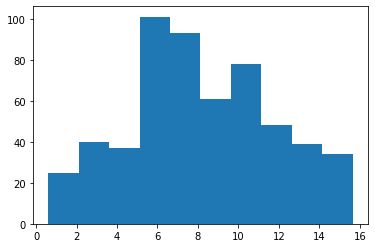

In [63]:
plt.hist(data2 | mp.select_field('age') | mp.as_list)

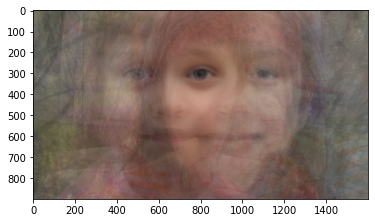

In [78]:
img = (data2
| mp.apply('age','flag',lambda x: x<8)
| balance(lambda x: x['flag'],n=7)
| mp.apply('imfname','image',lambda x: cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB))
| mp.apply(['image','descr','flag'],'face',transform)
| mp.select_field('face')
| mp.pexec(merge))

plt.imshow(img)

In [79]:
cv2.imwrite('d:/PICTURES_NEW/SciArt/Age3.jpg',imprint(cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB)))

True

In [119]:
width = 2000
height = 600
eye_line = 200
n_ppl = 5

dx = width // (n_ppl+2)

def get_tri(i):
    lx = dx*(i+1)
    rx = lx+dx
    mx = (lx+rx)//2
    return [(lx,eye_line),(rx,eye_line),(mx,eye_line+dx)]

triangles = [ get_tri(i) for i in range(n_ppl)]

def get_transform(descr,flag):
    flag = min(flag,len(triangles)-1)
    f = descr['faceLandmarks']
    mc_x = (f['mouthLeft']['x']+f['mouthRight']['x'])/2.0
    mc_y = (f['mouthLeft']['y'] + f['mouthRight']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['pupilLeft']['x'],f['pupilLeft']['y']),(f['pupilRight']['x'],f['pupilRight']['y']),(mc_x,mc_y)]),
                                np.float32(triangles[flag]))

def transform(args):
    image,descr,flag = args
    tr = get_transform(descr,flag)
    return cv2.warpAffine(image,tr,(width,height))

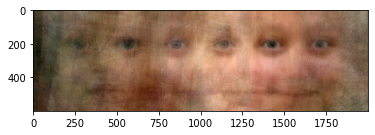

In [125]:
img = (data2
| mp.apply('age','flag',lambda x: int(x//3))
| balance(lambda x: x['flag'],n=10)
| mp.apply('imfname','image',lambda x: cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB))
| mp.apply(['image','descr','flag'],'face',transform)
| mp.select_field('face')
| mp.pexec(merge))

plt.imshow(img)

In [126]:
cv2.imwrite('d:/PICTURES_NEW/SciArt/Ages2.jpg',imprint(cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB)))

(600, 2000, 3) (120, 120, 4)


True

In [185]:
from math import sin,cos,pi
width = 2000
height = 2000
radius = 800
n_ppl = 8
da = 2*pi/360*5

def get_tri(i):
    a = i*2*pi/n_ppl
    x1 = width/2+radius*cos(a-da)
    y1 = height/2+radius*sin(a-da)
    x2 = width/2+radius*cos(a+da)
    y2 = height/2+radius*sin(a+da)
    x3 = width/2+(radius-150)*cos(a)
    y3 = height/2+(radius-150)*sin(a)
    return [(x1,y1),(x2,y2),(x3,y3)]

triangles = [ get_tri(i) for i in range(n_ppl)]

def get_transform(descr,flag):
    flag = min(flag,len(triangles)-1)
    f = descr['faceLandmarks']
    mc_x = (f['mouthLeft']['x']+f['mouthRight']['x'])/2.0
    mc_y = (f['mouthLeft']['y'] + f['mouthRight']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['pupilLeft']['x'],f['pupilLeft']['y']),(f['pupilRight']['x'],f['pupilRight']['y']),(mc_x,mc_y)]),
                                np.float32(triangles[flag]))

def transform(args):
    image,descr,flag = args
    tr = get_transform(descr,flag)
    return cv2.warpAffine(image,tr,(width,height))

In [186]:
triangles

[[(1796.9557584733966, 930.2754058018735),
  (1796.9557584733966, 1069.7245941981266),
  (1650.0, 1000.0)],
 [(1612.8355544951824, 1514.2300877492314),
  (1514.2300877492316, 1612.8355544951824),
  (1459.619407771256, 1459.619407771256)],
 [(1069.7245941981264, 1796.9557584733966),
  (930.2754058018736, 1796.9557584733966),
  (1000.0, 1650.0)],
 [(485.76991225076847, 1612.8355544951824),
  (387.16444550481765, 1514.2300877492316),
  (540.3805922287441, 1459.619407771256)],
 [(203.0442415266035, 1069.7245941981266),
  (203.0442415266035, 930.2754058018736),
  (350.0, 1000.0000000000001)],
 [(387.16444550481754, 485.7699122507686),
  (485.76991225076847, 387.16444550481765),
  (540.380592228744, 540.3805922287441)],
 [(930.2754058018734, 203.0442415266035),
  (1069.7245941981264, 203.0442415266035),
  (999.9999999999999, 350.0)],
 [(1514.2300877492314, 387.16444550481754),
  (1612.8355544951824, 485.76991225076836),
  (1459.6194077712557, 540.380592228744)]]

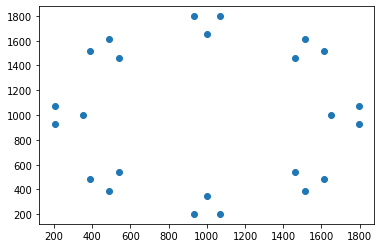

In [187]:
tx = [x[0] for t in triangles for x in t]
ty = [x[1] for t in triangles for x in t]
plt.scatter(tx,ty)

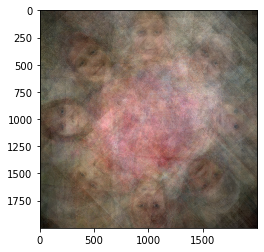

In [195]:
img = (data2
| mp.apply('age','flag',lambda x: int(x//2))
| balance(lambda x: x['flag'],n=10)
| mp.apply('imfname','image',lambda x: cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB))
| mp.apply(['image','descr','flag'],'face',transform)
| mp.select_field('face')
| mp.pexec(merge))

plt.imshow(img)

In [196]:
cv2.imwrite('d:/PICTURES_NEW/SciArt/Circ3.jpg',imprint(cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB)))

(2000, 2000, 3) (120, 120, 4)


True